# NucSegAI Result Analysis - Cell Type Quantification

This notebook analyzes NucSegAI JSON output files to extract:
- Cell counts by type
- Cell type proportions
- Type probability statistics

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Type probability statistics (min, median, mean, max, standard deviation)
4. ✅ Visualizations (bar charts, pie charts)
5. ✅ CSV export functionality
6. ✅ Batch processing for all json files

---

## Step 1: Import Required Libraries

In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Define Cell Type Dictionary

This mapping translates numeric cell type IDs to human-readable names.

In [5]:
# Cell type mapping
CELL_TYPE_DICT = {
    0: "Undefined",
    1: "Epithelium (PD-L1lo/Ki67lo)",
    2: "Epithelium (PD-L1hi/Ki67hi)",
    3: "Macrophage",
    4: "Lymphocyte",
    5: "Vascular",
    6: "Fibroblast/Stroma"
}

# Color mapping for visualization (converted from RGB to hex)
CELL_TYPE_COLORS = {
    0: "#000000",  # Black (RGB: 0, 0, 0) - Undefined
    1: "#387F39",  # Dark Green (RGB: 56, 127, 57) - Epithelium low
    2: "#00FF00",  # Bright Green (RGB: 0, 255, 0) - Epithelium high
    3: "#FC8D62",  # Coral/Salmon (RGB: 252, 141, 98) - Macrophage
    4: "#FFD92F",  # Yellow (RGB: 255, 217, 47) - Lymphocyte
    5: "#4535C1",  # Blue/Purple (RGB: 69, 53, 193) - Vascular
    6: "#17BECF"   # Cyan (RGB: 23, 190, 207) - Fibroblast/Stroma
}

print("Cell Type Mapping:")
for type_id, type_name in CELL_TYPE_DICT.items():
    print(f"  {type_id}: {type_name} -> {CELL_TYPE_COLORS[type_id]}")

Cell Type Mapping:
  0: Undefined -> #000000
  1: Epithelium (PD-L1lo/Ki67lo) -> #387F39
  2: Epithelium (PD-L1hi/Ki67hi) -> #00FF00
  3: Macrophage -> #FC8D62
  4: Lymphocyte -> #FFD92F
  5: Vascular -> #4535C1
  6: Fibroblast/Stroma -> #17BECF


## Step 3: Define Function to Analyze Single JSON File

This function reads a single JSON file and extracts all relevant statistics.

In [6]:
def analyze_single_json(json_path):
    """
    Analyze a single NucSegAI JSON output file.
    
    Parameters:
    -----------
    json_path : str or Path
        Path to the JSON file
    
    Returns:
    --------
    dict : Dictionary containing analysis results
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract nucleus data
    nuclei = data.get('nuc', {})
    
    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'total_cells': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'type_prob_stats': {}
        }
    
    # Initialize storage
    cell_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    
    # Extract data from each nucleus
    for nucleus_id, nucleus_data in nuclei.items():
        cell_type = nucleus_data.get('type',        0)
        type_prob = nucleus_data.get('type_prob',   0)
        
        cell_types.append(cell_type)
        type_probs.append(type_prob)
        type_probs_by_type[cell_type].append(type_prob)
    
    # Count cells by type
    cell_counts = Counter(cell_types)
    total_cells = len(cell_types)
    
    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells
    
    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min':      np.min(type_probs) if type_probs else 0,
        'median':   np.median(type_probs) if type_probs else 0,
        'mean':     np.mean(type_probs) if type_probs else 0,
        'max':      np.max(type_probs) if type_probs else 0,
        'std':      np.std(type_probs) if type_probs else 0
    }
    
    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min':      np.min(probs),
            'median':   np.median(probs),
            'mean':     np.mean(probs),
            'max':      np.max(probs),
            'std':      np.std(probs)
        }
    
    return {
        'filename': Path(json_path).name,
        'total_cells': total_cells,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type
    }

print("✅ Function defined: analyze_single_json()")

✅ Function defined: analyze_single_json()


## Step 4: Display Results Function

Create a function to display results in a readable format.

In [7]:
def display_results(results):
    """
    Display analysis results in a formatted way.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    print("="*80)
    print(f"Analysis Results for: {results['filename']}")
    print("="*80)
    print(f"\n📊 Total Cells Detected: {results['total_cells']:,}\n")
    
    # Cell Counts and Proportions
    print("─" * 80)
    print("Cell Type Distribution")
    print("─" * 80)
    print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>10}")
    print("─" * 80)
    
    for cell_type in sorted(results['cell_counts'].keys()):
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]
        percentage = proportion * 100
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>9.2f}%")
    
    # Overall Type Probability Statistics
    print("\n" + "─" * 80)
    print("Overall Type Probability Statistics")
    print("─" * 80)
    stats = results['type_prob_stats_overall']
    print(f"  Minimum:  {stats['min']:.10f}")
    print(f"  Median:   {stats['median']:.10f}")
    print(f"  Mean:     {stats['mean']:.10f}")
    print(f"  Maximum:  {stats['max']:.10f}")
    print(f"  Std Dev:  {stats['std']:.10f}")
    
    # Type Probability Statistics by Cell Type
    print("\n" + "─" * 80)
    print("Type Probability Statistics by Cell Type")
    print("─" * 80)
    
    for cell_type in sorted(results['type_prob_stats_by_type'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        stats = results['type_prob_stats_by_type'][cell_type]
        print(f"\n{type_name}:")
        print(f"  Min: {stats['min']:.6f} | Med: {stats['median']:.6f} | Mean: {stats['mean']:.6f} | Max: {stats['max']:.6f} | Std: {stats['std']:.6f}")
    
    print("\n" + "="*80)

print("✅ Function defined: display_results()")

✅ Function defined: display_results()


## Step 5: Visualization Functions

In [8]:
def plot_cell_type_distribution(results):
    """
    Create visualizations for cell type distribution.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data
    cell_types = sorted(results['cell_counts'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    counts = [results['cell_counts'][ct] for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]
    
    # Bar plot
    bars = axes[0].bar(range(len(cell_types)), counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Cell Counts by Type\n{results["filename"]}', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    axes[0].set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    axes[0].grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Pie chart with autopct for percentages only on larger slices
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 3 else ''  # Only show percentage if > 3%

    # Create pie chart with legend instead of labels for small slices
    wedges, texts, autotexts = axes[1].pie(
        counts,
        labels=None,  # Don't add labels directly to avoid overlap
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )

    # Create legend with labels and percentages
    legend_labels = [f'{name}: {count:,} ({count/sum(counts)*100:.1f}%)'
                     for name, count in zip(cell_names, counts)]
    axes[1].legend(
        wedges,
        legend_labels,
        title="Cell Types",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=9
    )

    axes[1].set_title(f'Cell Type Proportions\n{results["filename"]}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_type_probability_distribution(results):
    """
    Create bar plot for type probabilities by cell type.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    cell_types = sorted(results['type_prob_stats_by_type'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]

    # Create bar plot for mean values with error bars
    means = [results['type_prob_stats_by_type'][ct]['mean'] for ct in cell_types]
    stds = [results['type_prob_stats_by_type'][ct]['std'] for ct in cell_types]
    colors_list = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    bars = ax.bar(range(len(cell_types)), means, yerr=stds, color=colors_list,
                   edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)

    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Type Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Type Probability by Cell Type (Mean ± Std Dev)\n{results["filename"]}',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    ax.set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


## Step 6: Analyze Single JSON File

**👉 Update the path below to point to your JSON file**

✅ File found: /mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json/tile_39520_7904.json
Analysis Results for: tile_39520_7904.json

📊 Total Cells Detected: 2,503

────────────────────────────────────────────────────────────────────────────────
Cell Type Distribution
────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion Percentage
────────────────────────────────────────────────────────────────────────────────
Undefined                                     49       0.0196      1.96%
Epithelium (PD-L1lo/Ki67lo)                  191       0.0763      7.63%
Epithelium (PD-L1hi/Ki67hi)                  217       0.0867      8.67%
Macrophage                                   228       0.0911      9.11%
Lymphocyte                                 1,541       0.6157     61.57%
Vascular                                      10       0.0040      0.40%
Fibrobla

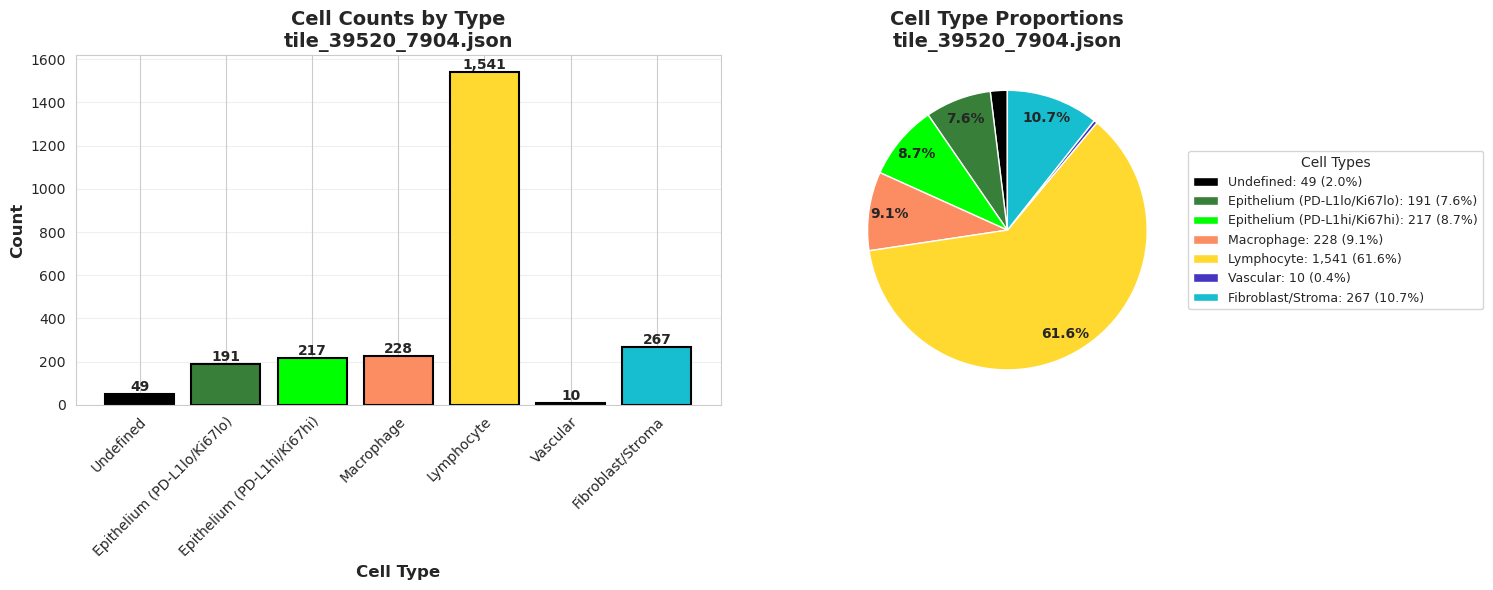

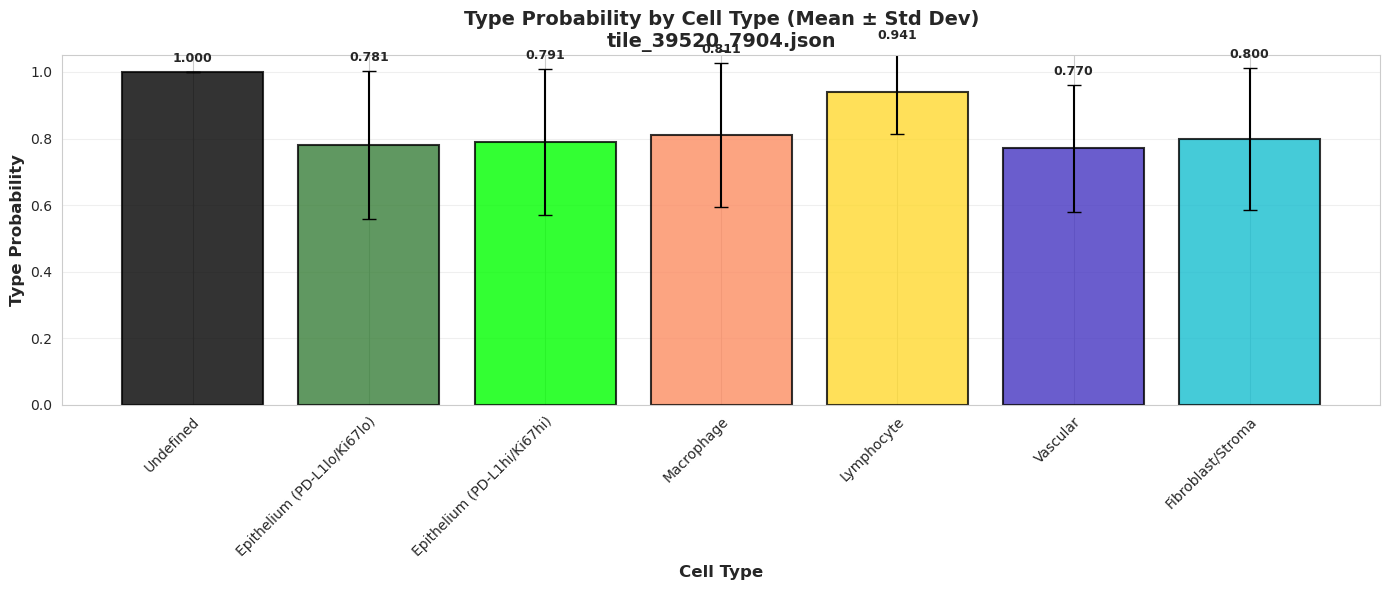

In [9]:
# ⚠️ UPDATE THIS PATH TO YOUR JSON FILE
json_file_path = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json/tile_39520_7904.json"  # Change this to your file path

# Check if file exists
if not Path(json_file_path).exists():
    print(f"❌ Error: File not found at {json_file_path}")
    print("Please update the json_file_path variable with the correct path.")
else:
    print(f"✅ File found: {json_file_path}")
    
    # Analyze the file
    results = analyze_single_json(json_file_path)
    
    # Display results
    display_results(results)
    
    # Create visualizations
    print("\n📊 Generating visualizations...\n")
    plot_cell_type_distribution(results)
    plot_type_probability_distribution(results)

## Step 7: Apply Confidence Threshold Filter

In [35]:
"""
## Step 7: Apply Confidence Threshold Filter

Filter out low-confidence predictions and reclassify them as "Undefined".
"""

def apply_confidence_filter(json_path, threshold=0.5):
    """
    Apply confidence threshold filter to reclassify low-confidence predictions.

    Parameters:
    -----------
    json_path : str or Path
        Path to the JSON file
    threshold : float
        Minimum type probability threshold (default: 0.5)

    Returns:
    --------
    dict : Filtered analysis results
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract nucleus data
    nuclei = data.get('nuc', {})

    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'threshold': threshold,
            'total_cells': 0,
            'reclassified_count': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'type_prob_stats_overall': {},
            'type_prob_stats_by_type': {}
        }

    # Initialize storage
    original_types = []
    filtered_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    reclassified_count = 0

    # Apply filter and extract data
    for nucleus_id, nucleus_data in nuclei.items():
        original_type = nucleus_data.get('type', 0)
        type_prob = nucleus_data.get('type_prob', 0)

        original_types.append(original_type)

        # Apply filter: reclassify to Undefined (0) if below threshold
        if type_prob < threshold and original_type != 0:
            filtered_type = 0  # Reclassify as Undefined
            reclassified_count += 1
        else:
            filtered_type = original_type

        filtered_types.append(filtered_type)
        type_probs.append(type_prob)
        type_probs_by_type[filtered_type].append(type_prob)

    # Count cells by filtered type
    cell_counts = Counter(filtered_types)
    total_cells = len(filtered_types)

    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells

    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min': np.min(type_probs) if type_probs else 0,
        'median': np.median(type_probs) if type_probs else 0,
        'mean': np.mean(type_probs) if type_probs else 0,
        'max': np.max(type_probs) if type_probs else 0,
        'std': np.std(type_probs) if type_probs else 0
    }

    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min': np.min(probs),
            'median': np.median(probs),
            'mean': np.mean(probs),
            'max': np.max(probs),
            'std': np.std(probs)
        }

    return {
        'filename': f"threshold_{int(threshold*100)}_"+Path(json_path).name,
        'threshold': threshold,
        'total_cells': total_cells,
        'reclassified_count': reclassified_count,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type,
        'original_cell_counts': dict(Counter(original_types))
    }

print("✅ Filtering functions defined")

✅ Filtering functions defined


Applying confidence threshold filter: 0.5


📊 Generating comparison visualizations...

Analysis Results for: threshold_50_tile_39520_7904.json

📊 Total Cells Detected: 2,503

────────────────────────────────────────────────────────────────────────────────
Cell Type Distribution
────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion Percentage
────────────────────────────────────────────────────────────────────────────────
Undefined                                    174       0.0695      6.95%
Epithelium (PD-L1lo/Ki67lo)                  167       0.0667      6.67%
Epithelium (PD-L1hi/Ki67hi)                  196       0.0783      7.83%
Macrophage                                   209       0.0835      8.35%
Lymphocyte                                 1,511       0.6037     60.37%
Vascular                                      10       0.0040      0.40%
Fibroblast/Stroma                            236

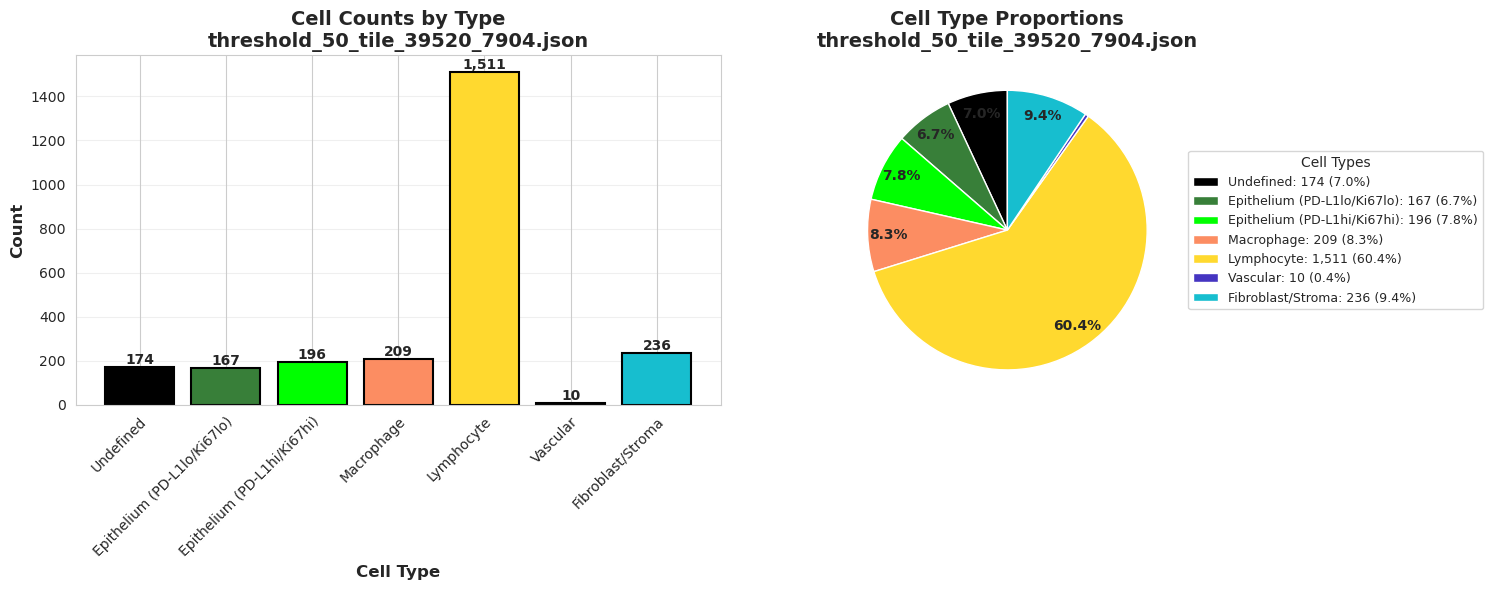

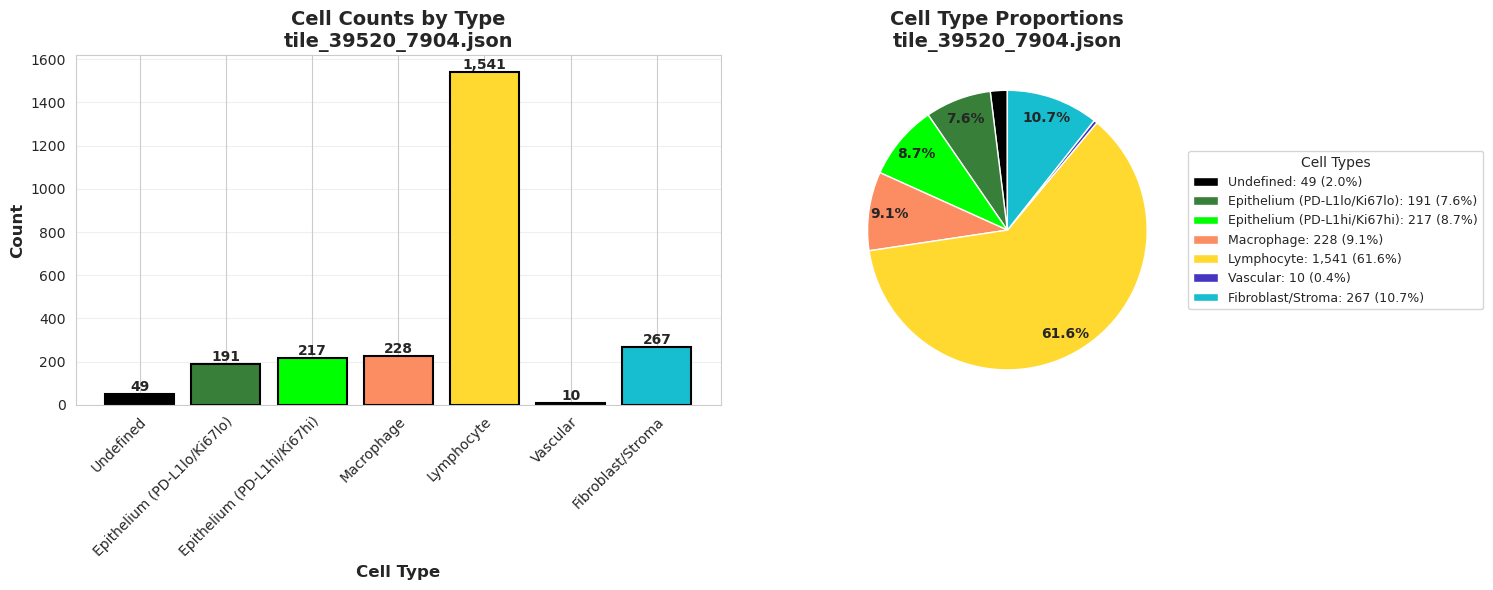

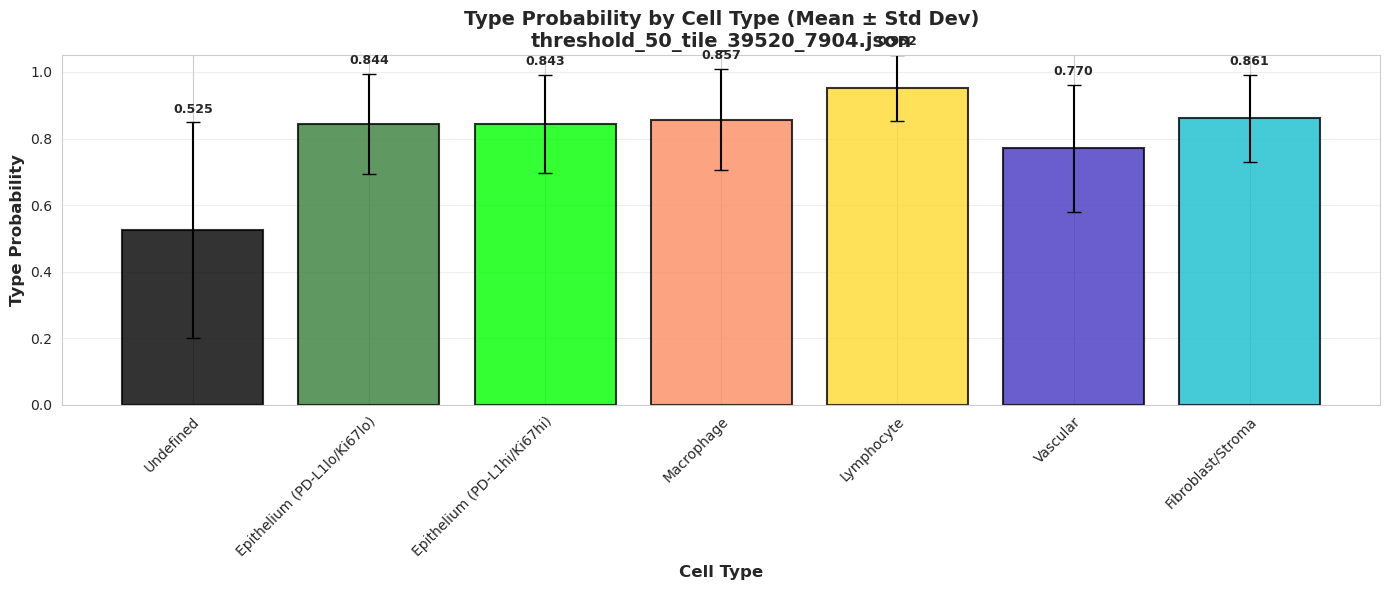

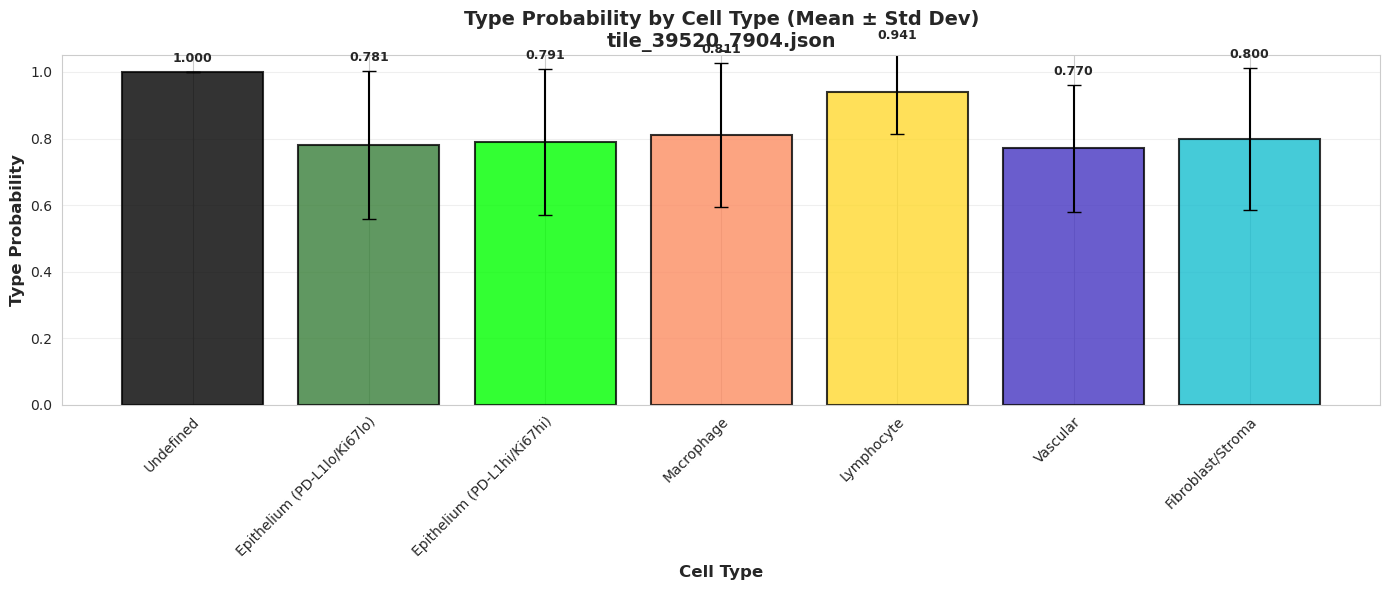

In [36]:
# ⚠️ Set your threshold here (default: 0.5)
CONFIDENCE_THRESHOLD = 0.5

if 'results' in locals():
    print(f"Applying confidence threshold filter: {CONFIDENCE_THRESHOLD}\n")

    # Apply filter
    filtered_results = apply_confidence_filter(json_file_path, threshold=CONFIDENCE_THRESHOLD)

    print("\n📊 Generating comparison visualizations...\n")

    display_results(filtered_results)
    display_results(results)
    # Display filtered results
    plot_cell_type_distribution(filtered_results)
    plot_cell_type_distribution(results)

    # Create comparison visualizations
    plot_type_probability_distribution(filtered_results)
    plot_type_probability_distribution(results)

else:
    print("⚠️ No results to filter. Please run Step 6 first.")

## Step 8: Export Results to CSV/Excel

In [12]:
"""
## Step 8: Export Results to CSV/Excel

Export both original (unfiltered) and filtered results to separate CSV files.
"""

def export_results_to_csv(results, output_path="cell_analysis_results.csv", is_filtered=False):
    """
    Export analysis results to CSV file.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json() or apply_confidence_filter()
    output_path : str
        Path for output CSV file
    is_filtered : bool
        Whether these are filtered results (adds threshold info)
    """
    # Prepare data for DataFrame
    data_rows = []

    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]

        stats = results['type_prob_stats_by_type'][cell_type]

        row_data = {
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100,
            'TypeProb_Min': stats['min'],
            'TypeProb_Median': stats['median'],
            'TypeProb_Mean': stats['mean'],
            'TypeProb_Max': stats['max'],
            'TypeProb_Std': stats['std']
        }

        # Add filtered-specific columns
        if is_filtered:
            row_data['Original_Count'] = results['original_cell_counts'].get(cell_type, 0)
            row_data['Count_Change'] = count - results['original_cell_counts'].get(cell_type, 0)
            row_data['Threshold'] = results.get('threshold', 'N/A')

        data_rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Reorder columns for filtered results (Threshold at the end)
    if is_filtered:
        column_order = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Original_Count', 'Count', 'Count_Change', 'Proportion', 'Percentage',
                       'TypeProb_Min', 'TypeProb_Median', 'TypeProb_Mean', 'TypeProb_Max',
                       'TypeProb_Std', 'Threshold']
        df = df[column_order]

    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Results exported to: {output_path}")

    return df

# Export both unfiltered and filtered results
print("="*80)
print("Exporting Results to CSV")
print("="*80)

if 'results' in locals() and 'filtered_results' in locals():
    # Export original (unfiltered) results
    print("\n📁 Exporting unfiltered results...")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )

    # Export filtered results with threshold in filename
    threshold_value = filtered_results.get('threshold', 0.5)
    threshold_str = str(int(threshold_value * 100))  # Convert 0.5 to "50"
    filtered_output_path = f"cell_analysis_filtered_{threshold_str}.csv"

    print("\n📁 Exporting filtered results...")
    df_filtered = export_results_to_csv(
        filtered_results,
        output_path=filtered_output_path,
        is_filtered=True
    )

    # Display both DataFrames
    print("\n" + "─"*80)
    print("Unfiltered Results Preview:")
    print("─"*80)
    display(df_original)

    print("\n" + "─"*80)
    print(f"Filtered Results Preview (Threshold: {threshold_value}):")
    print("─"*80)
    display(df_filtered)

    # Summary
    print("\n" + "="*80)
    print("Export Summary:")
    print("="*80)
    print(f"✅ Unfiltered results: cell_analysis_unfiltered.csv ({len(df_original)} rows)")
    print(f"✅ Filtered results:   {filtered_output_path} ({len(df_filtered)} rows)")
    print(f"📊 Total cells reclassified: {filtered_results.get('reclassified_count', 0):,}")

elif 'results' in locals():
    # Only unfiltered results available
    print("\n⚠️ Filtered results not available. Only exporting unfiltered results.")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )
    display(df_original)
    print("\n💡 Run Step 7 to generate filtered results before exporting.")

else:
    print("⚠️ No results to export. Please run Step 6 (and optionally Step 7) first.")

Exporting Results to CSV

📁 Exporting unfiltered results...
✅ Results exported to: cell_analysis_unfiltered.csv

📁 Exporting filtered results...
✅ Results exported to: cell_analysis_filtered_50.csv

────────────────────────────────────────────────────────────────────────────────
Unfiltered Results Preview:
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Proportion,Percentage,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std
0,tile_39520_7904.json,0,Undefined,49,0.019577,1.957651,1.000000,1.000000,1.000000,1.00000,6.270541e-09
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,0.076308,7.630843,0.013605,0.873684,0.781446,1.00000,2.224995e-01
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,0.086696,8.669596,0.035714,0.873272,0.790516,1.00000,2.191618e-01
3,tile_39520_7904.json,3,Macrophage,228,0.091091,9.109069,0.010204,0.909625,0.811077,1.00000,2.168358e-01
4,tile_39520_7904.json,4,Lymphocyte,1541,0.615661,61.566121,0.058824,0.992883,0.941281,1.00000,1.274014e-01
5,tile_39520_7904.json,5,Vascular,10,0.003995,0.399521,0.513126,0.787088,0.770378,0.99435,1.910125e-01
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,0.106672,10.667199,0.007722,0.889952,0.799950,1.00000,2.133720e-01



────────────────────────────────────────────────────────────────────────────────
Filtered Results Preview (Threshold: 0.5):
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Original_Count,Count,Count_Change,Proportion,Percentage,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std,Threshold
0,tile_39520_7904.json,0,Undefined,49,174,125,0.069517,6.951658,0.007722,0.450715,0.525022,1.00000,0.323875,0.5
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,167,-24,0.066720,6.671994,0.504273,0.894915,0.843649,1.00000,0.150737,0.5
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,196,-21,0.078306,7.830603,0.504178,0.903120,0.843094,1.00000,0.147420,0.5
3,tile_39520_7904.json,3,Macrophage,228,209,-19,0.083500,8.349980,0.501567,0.927807,0.856927,1.00000,0.151880,0.5
4,tile_39520_7904.json,4,Lymphocyte,1541,1511,-30,0.603676,60.367559,0.503759,0.993080,0.952439,1.00000,0.099416,0.5
5,tile_39520_7904.json,5,Vascular,10,10,0,0.003995,0.399521,0.513126,0.787088,0.770378,0.99435,0.191012,0.5
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,236,-31,0.094287,9.428686,0.513089,0.911459,0.860600,1.00000,0.130880,0.5



Export Summary:
✅ Unfiltered results: cell_analysis_unfiltered.csv (7 rows)
✅ Filtered results:   cell_analysis_filtered_50.csv (7 rows)
📊 Total cells reclassified: 125


## Step 9: Batch Analysis (All JSON Files)

Process all JSON files in a directory and aggregate results.

BATCH ANALYSIS - Processing All JSON Files

📊 Step 1: Analyzing unfiltered results...
Found 122 JSON files (unfiltered)
Processing...

Processed 10/122 files...
Processed 20/122 files...
Processed 30/122 files...
Processed 40/122 files...
Processed 50/122 files...
Processed 60/122 files...
Processed 70/122 files...
Processed 80/122 files...
Processed 90/122 files...
Processed 100/122 files...
Processed 110/122 files...
Processed 120/122 files...

✅ Completed! Processed 122 files.

AGGREGATED RESULTS - UNFILTERED
Total Files: 122
Total Cells: 114,336

────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion   Percentage
────────────────────────────────────────────────────────────────────────────────
Undefined                                  5,371       0.0470        4.70%
Epithelium (PD-L1lo/Ki67lo)                8,877       0.0776        7.76%
Epithelium (PD-L1hi/Ki67hi)               30,464       0

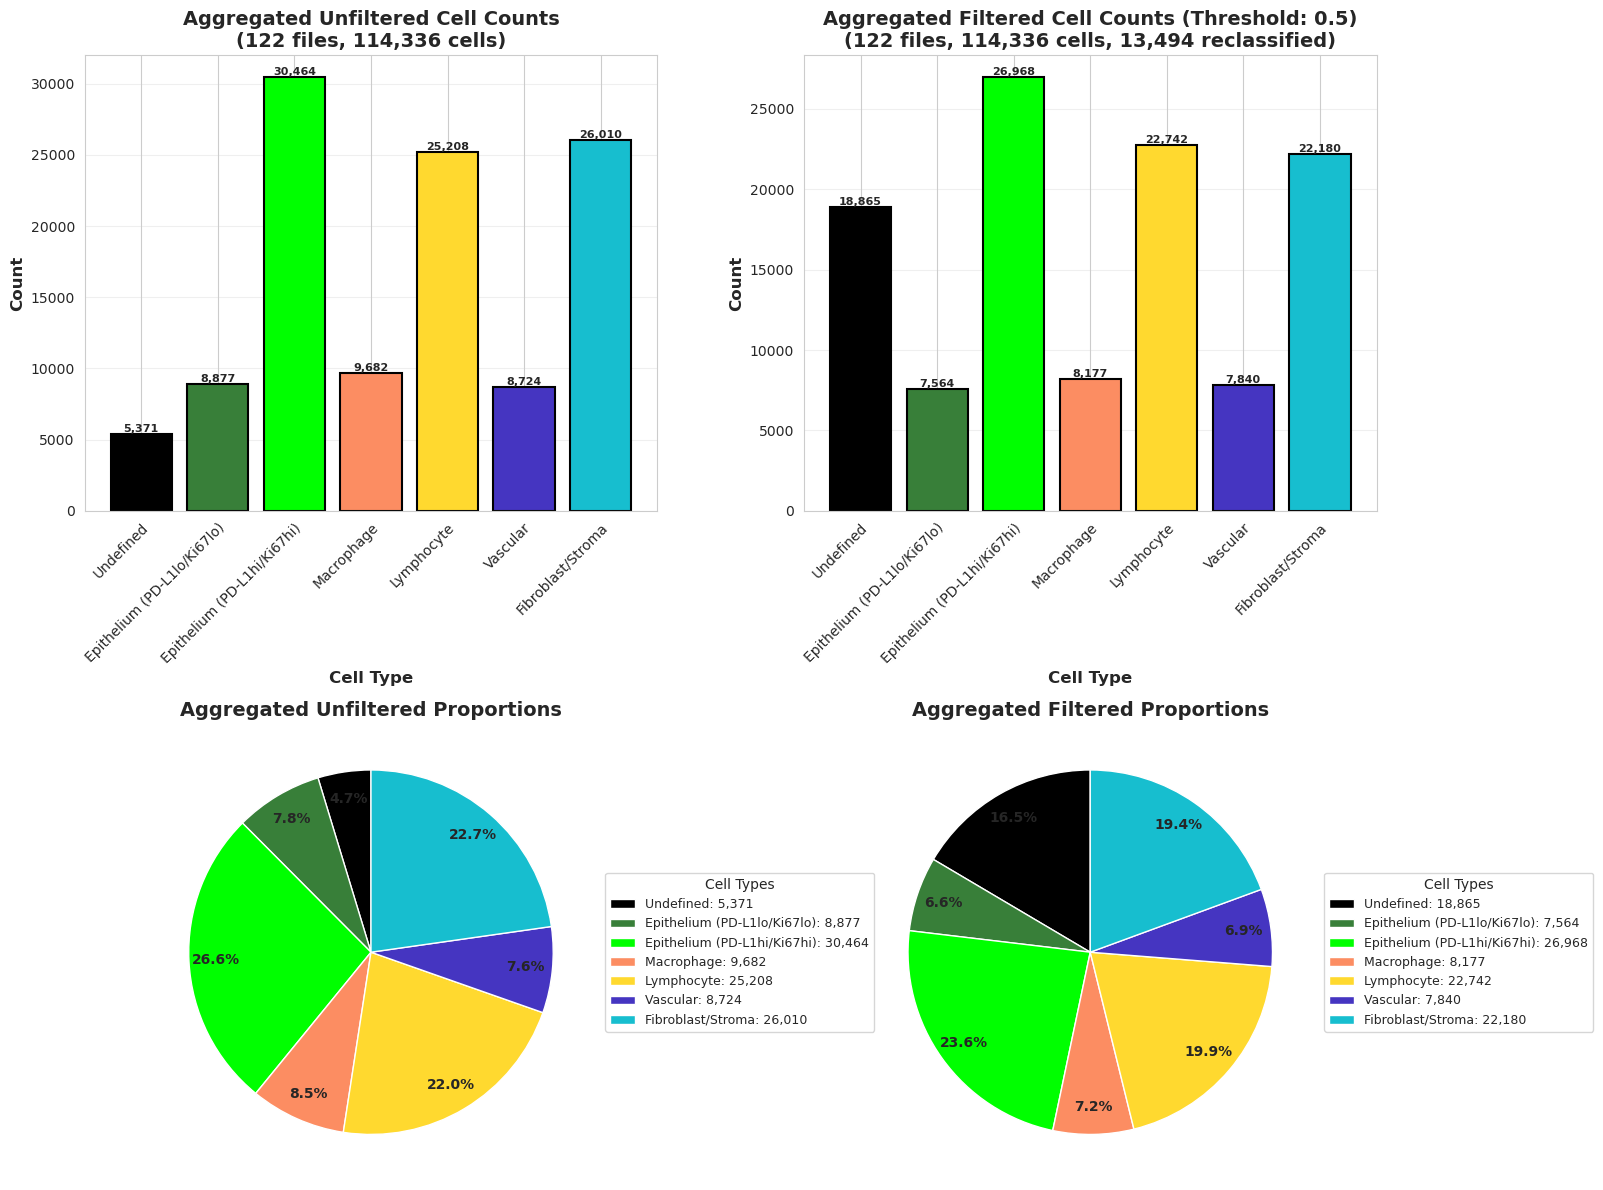


📊 Step 4: Exporting aggregated results to CSV...
✅ Aggregated results exported to: aggregated_results_unfiltered.csv
✅ Aggregated results exported to: aggregated_results_filtered_50.csv

BATCH ANALYSIS COMPLETE
✅ Processed 122 JSON files
✅ Total cells analyzed: 114,336
✅ Cells reclassified with threshold 0.5: 13,494

📁 Output files:
   - aggregated_results_unfiltered.csv
   - aggregated_results_filtered_50.csv

✅ Batch analysis complete!


In [13]:
"""
## Step 9: Batch Analysis (All JSON Files) - REFACTORED

Process all JSON files in a directory and aggregate results for both unfiltered and filtered data.
"""

# Configuration constants
PIE_CHART_MIN_PERCENT = 3.0
FIGURE_SIZE = (16, 12)
PROGRESS_INTERVAL = 10

def analyze_multiple_json_files(json_directory, apply_filter=False, threshold=0.5):
    """
    Analyze all JSON files in a directory.

    Parameters:
    -----------
    json_directory : str or Path
        Path to directory containing JSON files
    apply_filter : bool
        Whether to apply confidence threshold filter
    threshold : float
        Confidence threshold (only used if apply_filter=True)

    Returns:
    --------
    list : List of result dictionaries
    """
    json_dir = Path(json_directory)
    json_files = sorted(json_dir.glob("*.json"))

    if not json_files:
        print(f"❌ No JSON files found in {json_directory}")
        return []

    filter_status = f" (with filter threshold={threshold})" if apply_filter else " (unfiltered)"
    print(f"Found {len(json_files)} JSON files{filter_status}")
    print("Processing...\n")

    all_results = []
    process_func = (lambda f: apply_confidence_filter(f, threshold=threshold)) if apply_filter else analyze_single_json

    for i, json_file in enumerate(json_files, 1):
        if i % PROGRESS_INTERVAL == 0:
            print(f"Processed {i}/{len(json_files)} files...")
        all_results.append(process_func(json_file))

    print(f"\n✅ Completed! Processed {len(json_files)} files.")
    return all_results

def aggregate_results(all_results, is_filtered=False):
    """
    Aggregate results from multiple JSON files.

    Parameters:
    -----------
    all_results : list
        List of result dictionaries
    is_filtered : bool
        Whether these are filtered results

    Returns:
    --------
    dict : Aggregated statistics
    """
    total_cells_all = sum(r['total_cells'] for r in all_results)

    # Aggregate counts by cell type
    aggregated_counts = Counter()
    for result in all_results:
        aggregated_counts.update(result['cell_counts'])

    # Calculate overall proportions
    aggregated_proportions = {
        cell_type: count / total_cells_all
        for cell_type, count in aggregated_counts.items()
    }

    aggregated = {
        'total_files': len(all_results),
        'total_cells': total_cells_all,
        'aggregated_counts': dict(aggregated_counts),
        'aggregated_proportions': aggregated_proportions
    }

    # Add filtered-specific information
    if is_filtered:
        original_counts = Counter()
        for result in all_results:
            original_counts.update(result.get('original_cell_counts', {}))

        aggregated.update({
            'total_reclassified': sum(r.get('reclassified_count', 0) for r in all_results),
            'aggregated_original_counts': dict(original_counts),
            'threshold': all_results[0].get('threshold', 'N/A') if all_results else 'N/A'
        })

    return aggregated

def display_aggregated_results(aggregated, is_filtered=False):
    """
    Display aggregated results.

    Parameters:
    -----------
    aggregated : dict
        Aggregated results dictionary
    is_filtered : bool
        Whether these are filtered results
    """
    # Header
    title = "AGGREGATED RESULTS - FILTERED" if is_filtered else "AGGREGATED RESULTS - UNFILTERED"
    print(f"\n{'='*80}\n{title}")
    if is_filtered:
        print(f"Threshold: {aggregated.get('threshold', 'N/A')}")
    print(f"{'='*80}\nTotal Files: {aggregated['total_files']}\nTotal Cells: {aggregated['total_cells']:,}")

    if is_filtered:
        reclassified = aggregated.get('total_reclassified', 0)
        pct = reclassified / aggregated['total_cells'] * 100
        print(f"Total Reclassified: {reclassified:,} ({pct:.2f}%)")

    # Table header
    print(f"\n{'─'*80}")
    if is_filtered:
        print(f"{'Cell Type':<35} {'Original':>12} {'Filtered':>12} {'Change':>12} {'Proportion':>12}")
    else:
        print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>12}")
    print('─'*80)

    # Table rows
    for cell_type in sorted(aggregated['aggregated_counts'].keys()):
        type_name = CELL_TYPE_DICT[cell_type]
        count = aggregated['aggregated_counts'][cell_type]
        proportion = aggregated['aggregated_proportions'][cell_type]
        percentage = proportion * 100

        if is_filtered:
            original_count = aggregated.get('aggregated_original_counts', {}).get(cell_type, 0)
            change = count - original_count
            change_str = f"+{change:,}" if change >= 0 else f"{change:,}"
            print(f"{type_name:<35} {original_count:>12,} {count:>12,} {change_str:>12} {percentage:>11.2f}%")
        else:
            print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>11.2f}%")

    print('='*80)

def _create_bar_chart(ax, cell_types, cell_names, colors, counts, title):
    """Helper function to create a bar chart."""
    ax.bar(range(len(cell_types)), counts, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(cell_types)))
    ax.set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.grid(axis='y', alpha=0.3)
    for i, count in enumerate(counts):
        ax.text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

def _create_pie_chart(ax, cell_names, colors, counts, title):
    """Helper function to create a pie chart."""
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > PIE_CHART_MIN_PERCENT else ''

    wedges, _, _ = ax.pie(
        counts,
        labels=None,
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )
    legend_labels = [f'{name}: {count:,}' for name, count in zip(cell_names, counts)]
    ax.legend(wedges, legend_labels, title="Cell Types", loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    ax.set_title(title, fontsize=14, fontweight='bold')

def plot_aggregated_comparison(aggregated_unfiltered, aggregated_filtered):
    """
    Create comparison visualization of aggregated unfiltered vs filtered results.

    Parameters:
    -----------
    aggregated_unfiltered : dict
        Aggregated unfiltered results
    aggregated_filtered : dict
        Aggregated filtered results
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    # Get all cell types and prepare data
    all_cell_types = set(aggregated_unfiltered['aggregated_counts'].keys()) | \
                     set(aggregated_filtered['aggregated_counts'].keys())
    cell_types = sorted(all_cell_types)
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    unfiltered_counts = [aggregated_unfiltered['aggregated_counts'].get(ct, 0) for ct in cell_types]
    filtered_counts = [aggregated_filtered['aggregated_counts'].get(ct, 0) for ct in cell_types]

    # Create charts using helper functions
    _create_bar_chart(
        axes[0, 0], cell_types, cell_names, colors, unfiltered_counts,
        f'Aggregated Unfiltered Cell Counts\n({aggregated_unfiltered["total_files"]} files, '
        f'{aggregated_unfiltered["total_cells"]:,} cells)'
    )

    _create_bar_chart(
        axes[0, 1], cell_types, cell_names, colors, filtered_counts,
        f'Aggregated Filtered Cell Counts (Threshold: {aggregated_filtered.get("threshold", "N/A")})\n'
        f'({aggregated_filtered["total_files"]} files, {aggregated_filtered["total_cells"]:,} cells, '
        f'{aggregated_filtered.get("total_reclassified", 0):,} reclassified)'
    )

    _create_pie_chart(
        axes[1, 0], cell_names, colors, unfiltered_counts,
        'Aggregated Unfiltered Proportions'
    )

    _create_pie_chart(
        axes[1, 1], cell_names, colors, filtered_counts,
        'Aggregated Filtered Proportions'
    )

    plt.tight_layout()
    plt.show()

def export_aggregated_results(aggregated, output_path, is_filtered=False):
    """
    Export aggregated results to CSV.

    Parameters:
    -----------
    aggregated : dict
        Aggregated results dictionary
    output_path : str
        Output file path
    is_filtered : bool
        Whether these are filtered results
    """
    data_rows = []

    for cell_type in sorted(aggregated['aggregated_counts'].keys()):
        count = aggregated['aggregated_counts'][cell_type]
        proportion = aggregated['aggregated_proportions'][cell_type]

        row_data = {
            'Total_Files': aggregated['total_files'],
            'Total_Cells': aggregated['total_cells'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}"),
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100
        }

        if is_filtered:
            original_count = aggregated.get('aggregated_original_counts', {}).get(cell_type, 0)
            row_data.update({
                'Original_Count': original_count,
                'Count_Change': count - original_count,
                'Total_Reclassified': aggregated.get('total_reclassified', 0),
                'Threshold': aggregated.get('threshold', 'N/A')
            })

        data_rows.append(row_data)

    df = pd.DataFrame(data_rows)

    # Reorder columns for filtered results
    if is_filtered:
        column_order = ['Total_Files', 'Total_Cells', 'Total_Reclassified', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Original_Count', 'Count', 'Count_Change', 'Proportion', 'Percentage', 'Threshold']
        df = df[column_order]

    df.to_csv(output_path, index=False)
    print(f"✅ Aggregated results exported to: {output_path}")
    return df

def run_batch_analysis(json_directory, threshold=0.5):
    """
    Run complete batch analysis pipeline.

    Parameters:
    -----------
    json_directory : str or Path
        Path to directory containing JSON files
    threshold : float
        Confidence threshold for filtered analysis
    """
    print("="*80)
    print("BATCH ANALYSIS - Processing All JSON Files")
    print("="*80)

    # Process unfiltered results
    print("\n📊 Step 1: Analyzing unfiltered results...")
    all_results_unfiltered = analyze_multiple_json_files(json_directory, apply_filter=False)
    aggregated_unfiltered = aggregate_results(all_results_unfiltered, is_filtered=False)
    display_aggregated_results(aggregated_unfiltered, is_filtered=False)

    # Process filtered results
    print(f"\n📊 Step 2: Analyzing filtered results (threshold={threshold})...")
    all_results_filtered = analyze_multiple_json_files(json_directory, apply_filter=True, threshold=threshold)
    aggregated_filtered = aggregate_results(all_results_filtered, is_filtered=True)
    display_aggregated_results(aggregated_filtered, is_filtered=True)

    # Visualize comparison
    print("\n📊 Step 3: Generating comparison visualizations...")
    plot_aggregated_comparison(aggregated_unfiltered, aggregated_filtered)

    # Export results
    print("\n📊 Step 4: Exporting aggregated results to CSV...")
    df_agg_unfiltered = export_aggregated_results(
        aggregated_unfiltered,
        "aggregated_results_unfiltered.csv",
        is_filtered=False
    )

    threshold_str = str(int(threshold * 100))
    df_agg_filtered = export_aggregated_results(
        aggregated_filtered,
        f"aggregated_results_filtered_{threshold_str}.csv",
        is_filtered=True
    )

    # Summary
    print("\n" + "="*80)
    print("BATCH ANALYSIS COMPLETE")
    print("="*80)
    print(f"✅ Processed {aggregated_unfiltered['total_files']} JSON files")
    print(f"✅ Total cells analyzed: {aggregated_unfiltered['total_cells']:,}")
    print(f"✅ Cells reclassified with threshold {threshold}: {aggregated_filtered.get('total_reclassified', 0):,}")
    print("\n📁 Output files:")
    print("   - aggregated_results_unfiltered.csv")
    print(f"   - aggregated_results_filtered_{threshold_str}.csv")
    print("\n✅ Batch analysis complete!")

    return aggregated_unfiltered, aggregated_filtered

# ⚠️ UPDATE THIS PATH TO YOUR JSON DIRECTORY
json_directory = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json"
BATCH_THRESHOLD = 0.5

# Run the complete analysis
aggregated_unfiltered, aggregated_filtered = run_batch_analysis(json_directory, BATCH_THRESHOLD)

## Summary

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Type probability statistics (min, median, mean, max)
4. ✅ Visualizations (bar charts, pie charts)
5. ✅ CSV export functionality
6. ✅ Batch processing for all JSON files

**Next Steps:**
- Use these counts for spatial analysis
- Compare distributions across different tissue regions
- Correlate with clinical outcomes

---